In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
# sys.path.append('../../sportran/')
import sportran as st
import pandas as pd

In [25]:
import numpy as np
import matplotlib.pyplot as plt

In [276]:
scipy.interpolate.

In [395]:
from scipy.interpolate import CubicSpline, interp1d
def model_scalar(x, y):
    return CubicSpline(np.concatenate([-x[::-1], x[1:]]), np.concatenate([y[::-1], y[1:]]))

def model_wishart(x, y):
    xx = np.concatenate([-x[::-1], x[1:]])
    l = x.size
    y00, y01, y11 = y.reshape(3,l)
    yy = np.array([[y00, y01], [np.zeros_like(y01), y11]]).T
    # yy = np.einsum('tab,tbc->tac', np.transpose(yy, axes=(0,2,1)), yy)
    yy = np.concatenate([yy[::-1], yy[1:]])
    # return interp1d(xx, yy)) 
    return CubicSpline(xx, yy) #, bc_type = 'clamped')

In [396]:
LOG2=np.log(2)
from scipy.special import multigammaln
multig = multigammaln(0.5*3, 2)
def log_likelihood_wishart(w, model, omega, omega_fixed, data_, nu, ell):
        '''
        Logarithm of the Wishart probability density function.
        '''        
        n = ell
        p = 2

        # Compute scale matrix from the model (symmetrize to ensure positive definiteness)
        spline = model(omega_fixed, w)
        V = spline(omega)
        V = opt_einsum.contract('wba,wbc->wac', V, V) # equiv to V.T@V for each frequency

        # The argument of the PDF is the data
        X = data_ 
        
        # Determinant of X
        a, b, d = X[...,0,0], X[...,0,1], X[...,1,1]
        detX = a*d - b**2
        
        # Determinant and inverse of V
        a, b, d = V[...,0,0], V[...,0,1], V[...,1,1]
        invV = (1/(a*d - b**2)*np.array([[d, -b],[-b, a]])).transpose(2,0,1)
        detV = a*d - b**2

        # Trace of the matrix product between the inverse of V and X
        trinvV_X = opt_einsum.contract('wab,wba->w', invV, X)

        # if detV.min() < 0 or detX.min() < 0:
        #         print(detV.min(), detX.min())

        # Sum pieces of the log-likelihood
        log_pdf = 0.5*(-n*p*LOG2 - n*np.log(detV) + (n-p-1)*np.log(detX) - trinvV_X) - multig
        
        return np.sum(log_pdf)

def log_likelihood_offdiag(w, model, omega, omega_fixed, data_, nu, ell):
        '''
        Logarithm of the Variance-Gamma probability density function.
        '''
        import scipy.special as sp
        spline = model(omega_fixed, w)
        rho = np.clip(spline(omega), -0.98, 0.98)
        _alpha = 1/(1-rho**2)
        _beta = rho/(1-rho**2)
        _lambda = 0.5*ell*nu
        _gamma2 = np.abs(_alpha**2 - _beta**2)
        _lambda_minus_half = _lambda-0.5

        # Data is distributed according to a Variance-Gamma distribution with parameters (notation as in Wikipedia):
        # mu = 0; alpha = 1/(1-rho**2); beta = rho/(1-rho**2); lambda = ell*nu/2
        # Its expectation value is ell*nu*rho
        z = data_*ell*nu
        absz = np.abs(z)
        # z = data 
        # print([np.sum(i) for i in [_lambda*np.log(_gamma2), _lambda_minus_half*np.log(absz), 
        #       np.log(np.abs(sp.kv(_lambda_minus_half, _alpha*absz))), _beta*z,
        #        0.5*np.log(np.pi), np.log(sp.gamma(_lambda)), _lambda_minus_half*np.log(2*_alpha)]])

        log_pdf = _lambda*np.log(_gamma2) + _lambda_minus_half*np.log(absz) + np.log(np.abs(sp.kv(_lambda_minus_half, _alpha*absz))) + \
                _beta*z - 0.5*np.log(np.pi) - np.log(sp.gamma(_lambda)) - _lambda_minus_half*np.log(2*_alpha)

        res = np.sum(log_pdf)
        return res

def log_likelihood_diag(w, model, omega, omega_fixed, data_,  ell):
        spline = model(omega_fixed, w)
        rho = np.clip(spline(omega), 1e-6, 1e6)

        # Data is distributed according to a Chi-squared distribution with parameters (notation as in Wikipedia):
        # Its expectation value is ell*rho
        z = data_*ell/rho
        absz = np.abs(z)
        # z = data 
        log_pdf = (ell / 2 - 1)*np.log(absz) - absz/2 - np.log(rho)

        res = np.sum(log_pdf)
        return res + log_prior_diag(w)

def log_prior_diag(w):
        # Uniform prior
        if np.all((w>=1e-6)&(w<=1e6)):
                return 1
        else:
                return -np.inf

In [397]:
import scipy.optimize as opt

def do_mle_od(data_, w0, model, omega, omega_fixed, nu=2, ell=3, solver = 'BFGS'):    
    res = opt.minimize(fun = lambda w, model, omega, omega_fixed, data_, nu, ell: -log_likelihood_offdiag(w, model, omega, omega_fixed, data_, nu, ell),
                       x0 = w0,  
                       args = (model, omega, omega_fixed, data_, nu, ell),
                       method = solver)
    params = res.x   
    return params, res

def do_mle_d(data_, w0, model, omega, omega_fixed, ell=3, solver = 'BFGS'):    
    res = opt.minimize(fun = lambda w, model, omega, omega_fixed, data_, ell: -log_likelihood_diag(w, model, omega, omega_fixed, data_, ell),
                       x0 = w0,  
                       args = (model, omega, omega_fixed, data_, ell),
                       method = solver)
    params = res.x  
    return params, res

def do_mle_wishart(data_, w0, model, omega, omega_fixed, nu=2, ell=3, solver = 'CG'):    
    res = opt.minimize(fun = lambda w, model, omega, omega_fixed, data_, nu, ell: -log_likelihood_wishart(w, model, omega, omega_fixed, data_, nu, ell),
                       x0 = w0,  
                       args = (model, omega, omega_fixed, data_, nu, ell),
                       method = solver)
    params = res.x  
    return params, res

# Diagonal, off-diagonal estimates

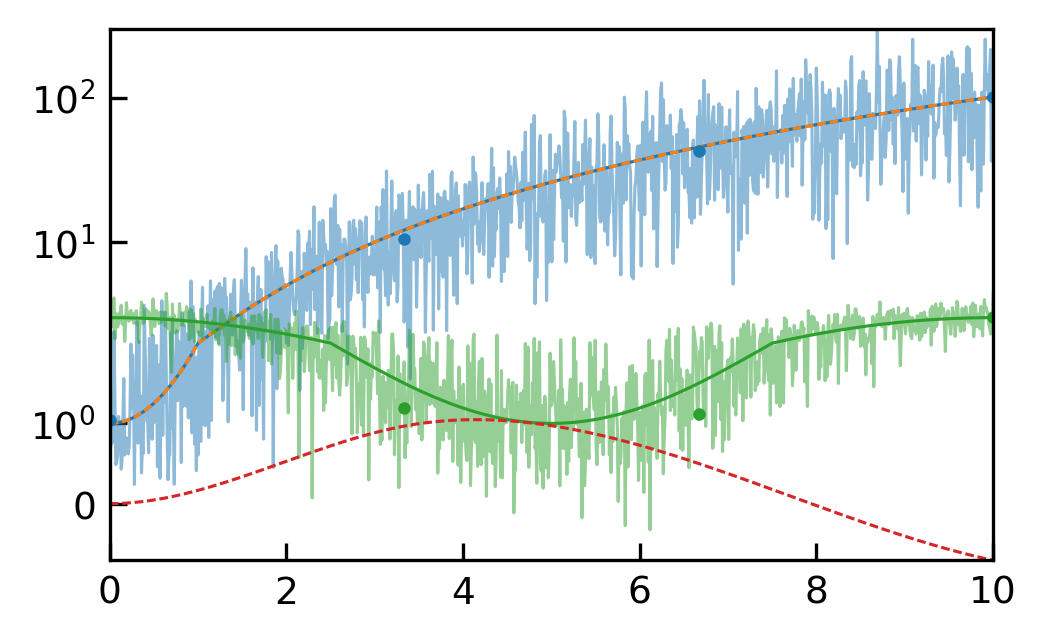

In [189]:
npar = 4
nsam = 1000

omega = np.linspace(0, 10, nsam, endpoint=True)
omega_fixed = np.linspace(0, 10, npar, endpoint=True)
w0 = np.random.randn(npar*3)

diag = np.abs(omega**2) + 1
off_diag = (1+1+np.cos(2*np.pi*omega*0.1))/3 * 3

diag_noise = np.random.chisquare(df = 6, size = diag.shape)/6
off_diag_noise = 0.5*np.random.normal(size=off_diag.shape)

data_diag = diag*diag_noise
data_offdiag = off_diag + off_diag_noise

guess_diag = pd.Series(data_diag).rolling(window=50, closed = 'left', min_periods = 0).mean().to_numpy()
guess_diag[0] = guess_diag[1]
guess_diag = np.array([guess_diag[j] for j in [np.argmin(np.abs(omega-omega_fixed[i])) for i in range(len(omega_fixed))]])
# guess_diag += np.random.normal(scale = 1, size = guess_diag.shape) 

guess_offdiag = pd.Series(data_offdiag).rolling(window=50, closed = 'left', min_periods = 0).mean().to_numpy()
guess_wishart[0] = guess_offdiag[1]
guess_offdiag = np.array([guess_offdiag[j] for j in [np.argmin(np.abs(omega-omega_fixed[i])) for i in range(len(omega_fixed))]])
guess_offdiag += np.random.normal(scale = 0.4, size = guess_offdiag.shape) 

true_params_diag = np.abs(omega_fixed**2) + 1
true_params_offdiag = np.sin(2*np.pi*omega_fixed/16) 
                       
diag_spline = model_scalar(omega_fixed, true_params_diag)
offdiag_spline = model_scalar(omega_fixed, true_params_offdiag)
splined_diag = diag_spline(omega)
splined_offdiag = offdiag_spline(omega)

fig, ax = plt.subplots()

for ydata, ytrue, yspline, yguess in zip([data_diag, data_offdiag], [diag, off_diag], 
                                         [splined_diag, splined_offdiag], [guess_diag, guess_offdiag]):
    pl, = ax.plot(omega, ydata, alpha = 0.5)
    ax.plot(omega, ytrue, color = pl.get_color(), markeredgecolor='black', markeredgewidth=0.5)
    ax.plot(omega, yspline, ls = '--')
    # ax.plot(omega, true_spline(omega)[:,i,j], ls = '--')
    ax.plot(omega_fixed, yguess, 'o', color = pl.get_color())
ax.set_yscale('symlog')

In [190]:
solver = 'BFGS'
params_d, res_d = do_mle_d(data_diag, guess_diag, model_scalar, omega, omega_fixed, solver = solver)

data_offdiag = np.loadtxt('/Users/paolo/data_offdiag.txt')[:nsam]
guess_offdiag = pd.Series(data_offdiag).rolling(window=70, closed = 'left', min_periods = 0).mean().to_numpy()
guess_offdiag[0] = guess_offdiag[1]
guess_offdiag = np.array([guess_offdiag[j] for j in [np.argmin(np.abs(omega-omega_fixed[i])) for i in range(len(omega_fixed))]])

params_od, res_od = do_mle_od(data_offdiag, guess_offdiag, model_scalar, omega, omega_fixed, solver = solver)

/var/folders/1h/l4hl5gdn4j55pcw3tbrrx2c80000gn/T/ipykernel_58334/1463231246.py:62: RuntimeWarning: divide by zero encountered in log
  log_pdf = _lambda*np.log(_gamma2) + _lambda_minus_half*np.log(absz) + np.log(np.abs(sp.kv(_lambda_minus_half, _alpha*absz))) + \
/Users/paolo/micromamba/envs/lammps/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


(0.0, 10.0)

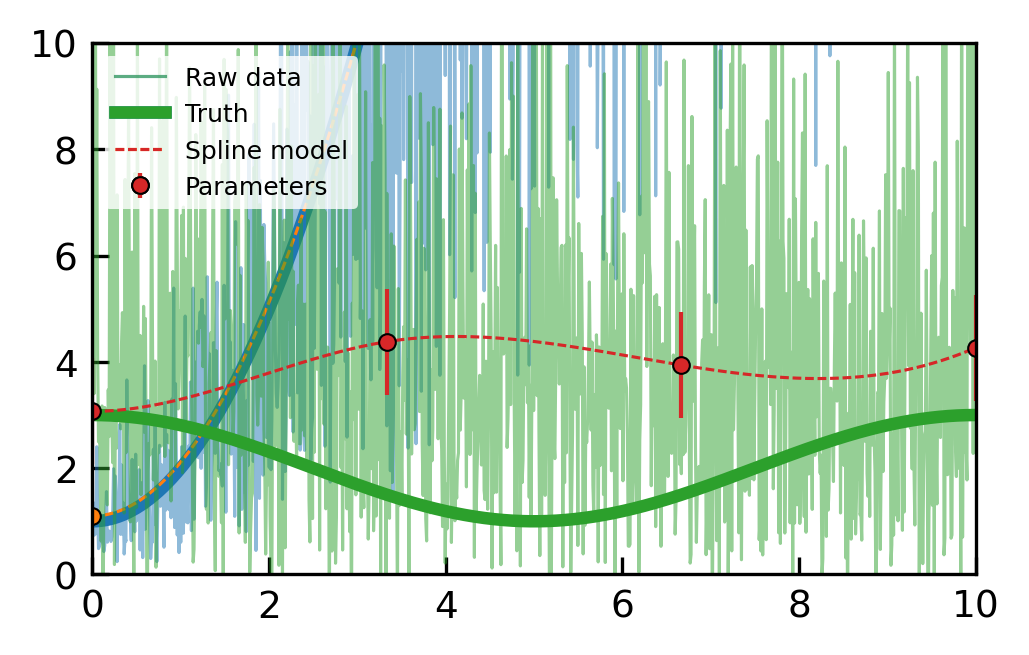

In [191]:
diag_spline = model_scalar(omega_fixed, params_d)
offdiag_spline = model_scalar(omega_fixed, params_od)
splined_diag = diag_spline(omega)
splined_offdiag = offdiag_spline(omega)

fig, ax = plt.subplots()

handles = [[], [], [], []]
labels = [[], [], [], []]
for ydata, ytrue, yspline, yguess,res in zip([data_diag, data_offdiag], [diag, off_diag], 
                                         [splined_diag, splined_offdiag], [guess_diag, guess_offdiag], [res_d, res_od]):
    pl, = ax.plot(omega, ydata, alpha = 0.5)
    handles[0].append(pl)
    labels[0] = 'Raw data'
    
    pl, = ax.plot(omega, ytrue, color = pl.get_color(), lw = 3)
    handles[1].append(pl)
    labels[1] = 'Truth'

    pls, = ax.plot(omega, yspline, ls = '--')
    handles[2].append(pls)
    labels[2] = 'Spline model'
    pl = ax.errorbar(omega_fixed, res.x, np.sqrt(res.hess_inv.diagonal()), 
                     color = pls.get_color(), 
                     lw = 0, 
                     elinewidth = 1,  
                     marker = 'o',
                     markeredgecolor = 'black', 
                     markeredgewidth = 0.5,
                     markersize = 4)
    handles[3].append(pl)
    labels[3] = 'Parameters'
    # pl, = ax.plot(omega_fixed, yguess, 'o', color = pl.get_color(), 
    #               markeredgecolor = 'black', markeredgewidth = '0.5')
    # handles[3].append(pl)
    # labels[3] = 'Initial guess'

ax.legend(handles = [tuple(h) for h in handles], labels = labels, loc = 'upper left', fontsize = 6)
# ax.set_yscale('symlog')
# ax.set_xlim(0,3)
ax.set_ylim(0,10)

# Wishart estimate

In [439]:
npar = 20
nsam = 10000

omega = np.linspace(0, 10, nsam, endpoint=True)
omega_fixed = np.linspace(0, 10, npar, endpoint=True)

data_wishart = np.loadtxt('/Users/paolo/data_wishart.txt')[:nsam]
truth_wishart = np.loadtxt('/Users/paolo/truth_wishart.txt')[:nsam]


guess_wishart = np.array([pd.Series(data_wishart[:,i]).rolling(window=50, 
                                                               closed = 'left', 
                                                               min_periods = 0, 
                                                               center = True).mean().to_numpy() for i in range(4)]).T.reshape(-1, 2, 2)
guess_wishart = np.array([guess_wishart[j] for j in [np.argmin(np.abs(omega-omega_fixed[i])) for i in range(len(omega_fixed))]])
guess_wishart = np.array([cholesky(g, lower = False) for g in guess_wishart])/np.sqrt(3)

data_wishart = data_wishart.reshape(-1,2,2)
truth_wishart = truth_wishart.reshape(-1,2,2)

solver = 'BFGS'
params, res = do_mle_wishart(data_wishart, 
                             np.array([guess_wishart[:,0,0],guess_wishart[:,0,1],guess_wishart[:,1,1]]).reshape(-1), 
                             model_wishart, omega, omega_fixed, solver = solver)

(0.0, 65.0)

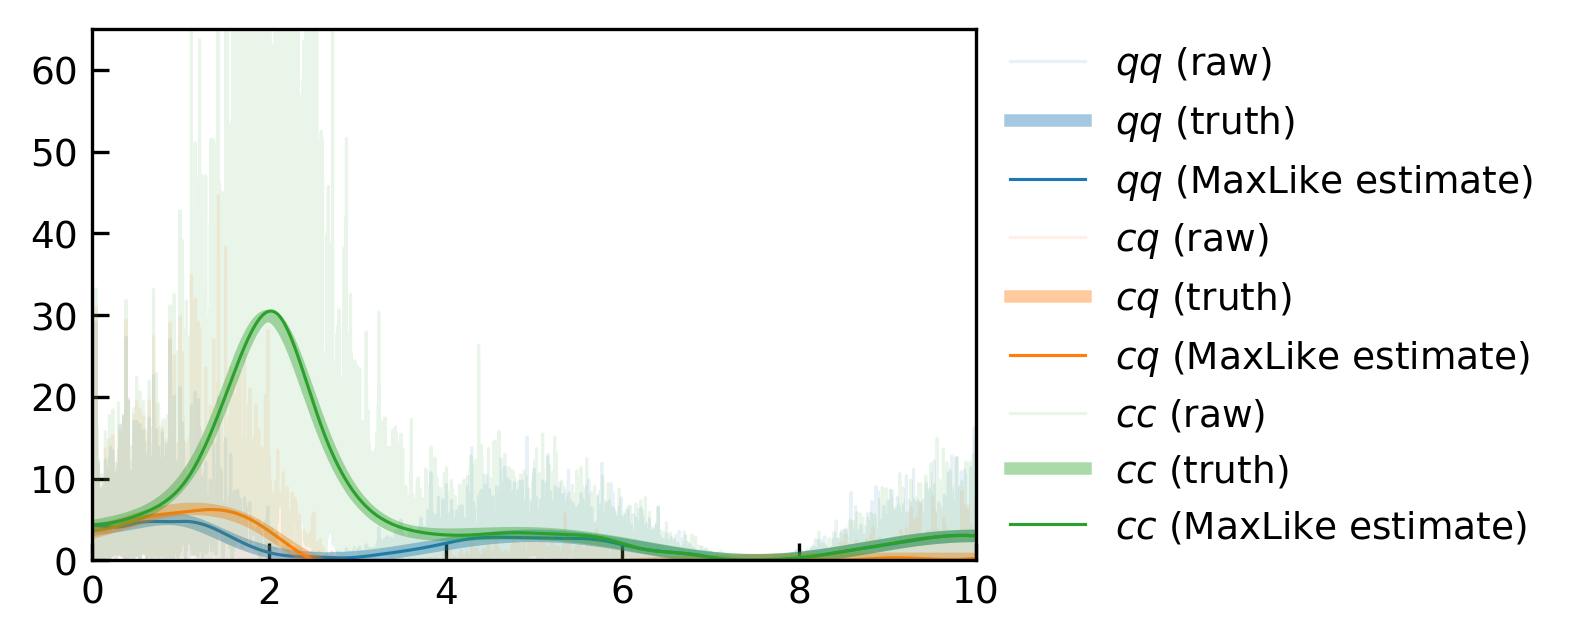

In [444]:
spline = model_wishart(omega_fixed, params)
# guess_spline = model_wishart(omega_fixed, np.array([guess_wishart[:,0,0], guess_wishart[:,0,1], guess_wishart[:,1,1]]).flatten())

fig, ax = plt.subplots()

estimate = spline(omega)
estimate = opt_einsum.contract('wba,wbc->wac', estimate, estimate)*3   # This should be 3*V, the expectation value of X

# par_mat = np.array([np.array([[p[0], p[1]], [0, p[2]]]) for p in params.reshape(npar, 3)])
# estimate_par = opt_einsum.contract('wba,wbc->wac', par_mat, par_mat)*3   # This should be 3*V, the expectation value of X

# par_0 = guess_spline(omega)
# par_0 = opt_einsum.contract('wba,wbc->wac', par_0, par_0)*3   # This should be 3*V, the expectation value of X
# par_0 = opt_einsum.contract('wba,wbc->wac', guess_wishart, guess_wishart)*3   # This should be 3*V, the expectation value of X
# par_0 = guess_wishart

# params_resh = res.x.reshape(3, npar)
# cov_resh = res.hess_inv.diagonal().reshape(3, npar)**0.5

comp = {(0,0): '$qq$', (0,1): '$cq$', (1,1): '$cc$'}

ip = 0
for i in range(2):
    for j in range(i, 2):
        pl, = ax.plot(omega, data_wishart[:, i, j], alpha = 0.1, label = f'{comp[i,j]} (raw)')
        ax.plot(omega, truth_wishart[:, i, j], color = pl.get_color(), alpha = 0.4, lw = 3, label = f'{comp[i,j]} (truth)')
        ax.plot(omega, estimate[:, i, j], color = pl.get_color(), ls = '-', label = f'{comp[i,j]} (MaxLike estimate)') 

        # ax.plot(omega_fixed, estimate_par[:, i,j], 'o' , markersize = 8, color = pl.get_color())
        # ax.plot(omega, par_0[:, i,j], ls='dotted', color = pl.get_color())
        # ax.plot(omega_fixed, par_0[:, i,j], '*', markersize = 8, color = pl.get_color())

        # pl = ax.errorbar(omega_fixed, params_resh[ip], cov_resh[ip], 
        #              color = pl.get_color(), 
        #              lw = 0, 
        #              elinewidth = 1,  
        #              marker = 'o',
        #              markeredgecolor = 'black', 
        #              markeredgewidth = 0.5,
        #              markersize = 4)
    
ax.legend(loc = 'center left', bbox_to_anchor = (1,0.5))
# ax.legend(handles = [tuple(h) for h in handles], labels = labels, loc = 'upper left', fontsize = 6)
# ax.set_yscale('symlog')
ax.set_xlim(0,10)
ax.set_ylim(0,65)

In [451]:
a00, a01, a11 = params.reshape(3, 20)[:, 0]
m = np.array

array([0.66098844, 0.997421  , 1.20562325])

In [447]:
truth_wishart[0]

array([[3.75      , 3.38495559],
       [3.38495559, 4.18435253]])